# Создание дашборда для анализа продаж на маркетплейсах (BI-аналитика)

## Введение

В связи с конфиденциальностью предоставленной для работы информации в описании проекта будут использоваться только скриншоты рабочего дашборда и описание его функциональности без демонстрации рабочей версии дашборда.

## Исследуемый набор данных

На исследование предоставлена база данных, содержащая более 60-и таблиц. В их числе имеются таблицы с информацией: о продажах на маркетплейсе Wildberries, о продуктах, о категориях продуктов, о складах, об остатках на складах. В таблицах содержится информация за несколько последних месяцев текущего года. База данных является обновляемой копией действующей базы производственного предприятия.

## Цели и задачи исследования

1. Создать дашборд, который поможет менеджерам предприятия оценивать в режиме реального времени результаты продаж на маркетплейсе и получать ответы на такие вопросы как: "какова прибыльность товаров по категориям за отрезок времени", "какие категории товаров и товарные позиции имеют анональные отклонения по прибыльности, на каком этапе происходят потери", "какова динамика продаж и прибыльности по неделям в разрезе вопронки прибыльности продаж".
2. Создать дашборд, который показывает оборачиваемость товаров на складах маркетплейса с целью выявления отклонений от номинальных показателей. Дашборд также должен помогать менеджерам принимать решения об объемах поставок конкретных товарных позиций на склады (или их перемещения с одного склада на другой) из расчета предполагаемого срока их реализации.
3. Для создания дашбордов использовать BI-систему DataLens.

## Общие требования к дашбордам

* Правильность расчетов и достоверность информации
* Соответствие ТЗ
* Удобство для работы и наглядность данных, стиль оформления - бизнес

## Декомпозиция

* Итоги работы будут выглядеть как 2 дашборда. 1-ый для анализа продаж, 2-ой для анализа оборачиваемости и планирования поставок на склады маркетплейса.
* На начальном этапе изучаем состав таблиц и определяем нужные для работы поля. На этом этапе также определяем нужены ли подзапросы SQL для извлечения данных из таблицы или данные будут обрабатываться после формирования датасета.
* Формируем датасеты для 1-го и 2-го дашбордов.
* Определяем какие итоговые поля нам потребуются для дашбордов и какими формулами они будут формироваться. Сопоставляем получаемые поля и формулы с ТЗ Заказчика.
* Проектируем и формируем чарты, которые будут использованы в дашбордах. Используем подготовленные ранее формулы для создание нужных полей (параметров и измерений).
* Создаем из чартов дашборды. Добавляем и настраиваем фильтры, селекторы и настраиваем их взаимосвязи.
* Проверяем корректность работы дашбордов и их соответствие ТЗ Заказчика.

## Подзапросы SQL

Для создания чарта расчета оборачиваемости и планирования поставок на склады потребовалось сформировать подзапросы SQL на этапе формирования датасета. Ниже приведен их код.

In [5]:
# Расчитывает поля, содержащие остатки товаров на складах по датам (учитывает возможное дублирование данных) 
'''
SELECT product_id as product_id_stock,
       date::date as stock_dt,
       SUM(quantity) / (COUNT(warehouse_id) / COUNT(DISTINCT warehouse_id)) as quantity 
FROM marketing_productstock p
LEFT JOIN marketing_warehouse w ON p.warehouse_id = w.id
WHERE type <> 'FBS'
GROUP BY product_id, date
'''

"\nSELECT product_id as product_id_stock,\n       date::date as stock_dt,\n       SUM(quantity) / (COUNT(warehouse_id) / COUNT(DISTINCT warehouse_id)) as quantity \nFROM marketing_productstock p\nLEFT JOIN marketing_warehouse w ON p.warehouse_id = w.id\nWHERE type <> 'FBS'\nGROUP BY product_id, date\n"

In [6]:
# Расчитывает поля, содержащие продажи товаров по дням и складам
'''
SELECT product_id,
       sale_dt::date,
       office_name,
       COUNT(CASE
              WHEN supplier_oper_name = 'Продажа' THEN 1
              WHEN supplier_oper_name = 'Сторно продаж' THEN -1
              WHEN supplier_oper_name = 'Возврат' THEN -1
              ELSE 1
              END) as sales_count
FROM marketing_realizationreport
WHERE supplier_oper_name in ('Продажа', 'Сторно продаж', 'Возврат', 'Сторно возвратов')
GROUP BY product_id, sale_dt, office_name
'''

"\nSELECT product_id,\n       sale_dt::date,\n       office_name,\n       COUNT(CASE\n              WHEN supplier_oper_name = 'Продажа' THEN 1\n              WHEN supplier_oper_name = 'Сторно продаж' THEN -1\n              WHEN supplier_oper_name = 'Возврат' THEN -1\n              ELSE 1\n              END) as sales_count\nFROM marketing_realizationreport\nWHERE supplier_oper_name in ('Продажа', 'Сторно продаж', 'Возврат', 'Сторно возвратов')\nGROUP BY product_id, sale_dt, office_name\n"

## Формирование датасетов

1. Сформирован датасет для чартов и дашборда анализа продаж. Датасет объединяет в себе 7 таблиц базы данных. При объединении таблиц использовался метод LEFT JOIN для предотвращения потери информации о продажах. Проведена настройка датасета, отклюбчены неиспользуемые поля. Добавлены новые расчетные поля, необходимые для корректной работы чарта.
2. Сформирован датасет для чартов и дашборла анализа оборачиваемости и планирования поставок на склады. Основанный на данном датасете чарт будет иметь определенный ограниченный функционал, поэтому лишние поля удалены. При объединении таблиц использовались методы FULL JOIN и LEFT JOIN для предотвращения потери информации о продажах и складских остатках. Добавлены новые расчетные поля, необходимые для корректной работы чарта.

## Формирование чартов

На базе созданных датасетов сформировано 8 чартов: 6 для дашборда продаж и 2 для дашборда складского планирования. Использованы типы чартов: линейчатая диаграмма и таблица. Для создания чартов использовались вновь созданные: измерения, показатели, иерархии. 

## Формирование дашбордов

### Дашборд "анализ продаж"

При формировании дашборда добавлены селекторы: "Даты" (период продаж), "Интервал" (временной интервал оценки динамики продаж), "Тип" (выбор модели продаж: FBO, FBS или оба типа), "Склад продаж" (позволяет выбрать склад с которого осуществлена продажа). Настроены взаимосвязи селекторов с чартами и между собой.

Ниже приведен скриншот дашборда (числовые значения скрыты).

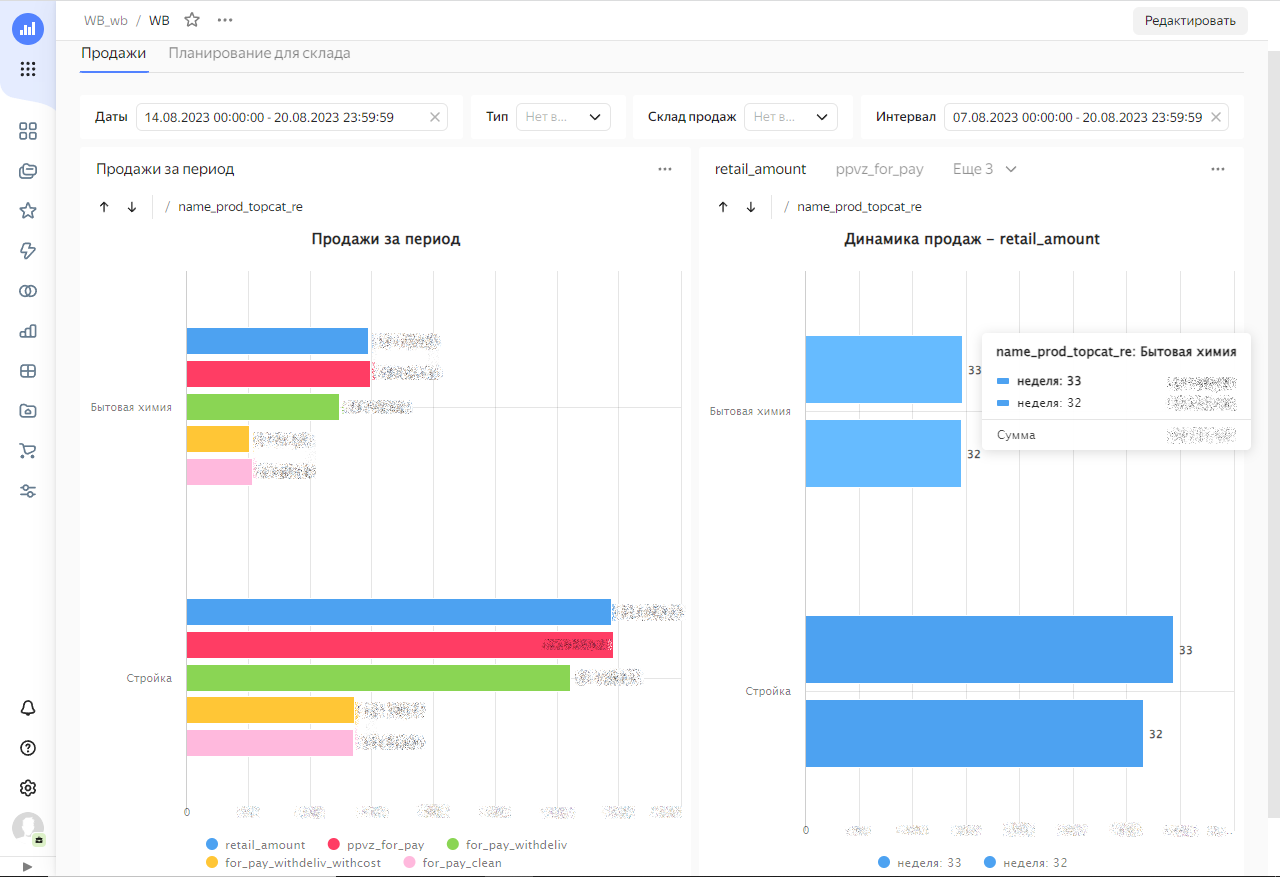

#### Логика дашборда

Дашборд реализует следующую логику.

С левой стороны расположена панель "воронки доходности" продаж. Под воронкой понимается последовательное добавление связанных с продажей затрат и надбавок/доплат (при наличии). Верхней планкой продажной стоимости взят показатель "retail_amount" - стоимость продажи с учетом скидок для покупателя. (Показатель стоимости продаж до скидок не брался в связи с возможным его искусственным образованием, то есть когда цена повышается для того, чтобы установить привлекательную скидку.) Следующий показатель "ppvz_for_pay" учитывает комиссии и надбавки/доплаты маркетплейса. Следующий показатель "for_pay_withdeliv" добавляет к предыдущим затраты на доставку. Следующий показатель "for_pay_withdeliv_withcost" добавляет к предыдущему себестоимость товара. Следующий показатель "for_pay_clean" учитывает оставшиеся затраты (штрафы) и возможные доплаты/надбавки. (Не учитывалась стоимость доставки силами партнеров маркетплейса, так как анализ данных показал, что указанные затраты одновременно сторнировались из комиссии маркетплейса и влияния на затраты продавца не оказывали).

С правой стороны расположена панель динамики продаж. Она позволяет сопоставить понедельно динамику продаж в разрезе каждого из приведенных выше показателей. Для удобства показатели в левой и правой панелях соотносятся по одинаковым цветам.

Обе панели (левая и правая) имеют иерархическую структуру в разрезе: верхняя категория товаров -> средняя категория товаров -> категория товаров -> наименование товара -> продажа товара (штрих-код продажи). Данная структура позволяет последовательно анализировать интересующие анамалии, гранулировать продажи для поиска причин отклонений вплоть до продажи конкретной позиции.

Дашборд позволяет производить сортировки по типу продаж и складам. При наведени курсора на конкретную продажу отображается информация с числовыми значениями продажи

Ниже приведены скриншоты дашборда с различными настройками (числовые значения скрыты).

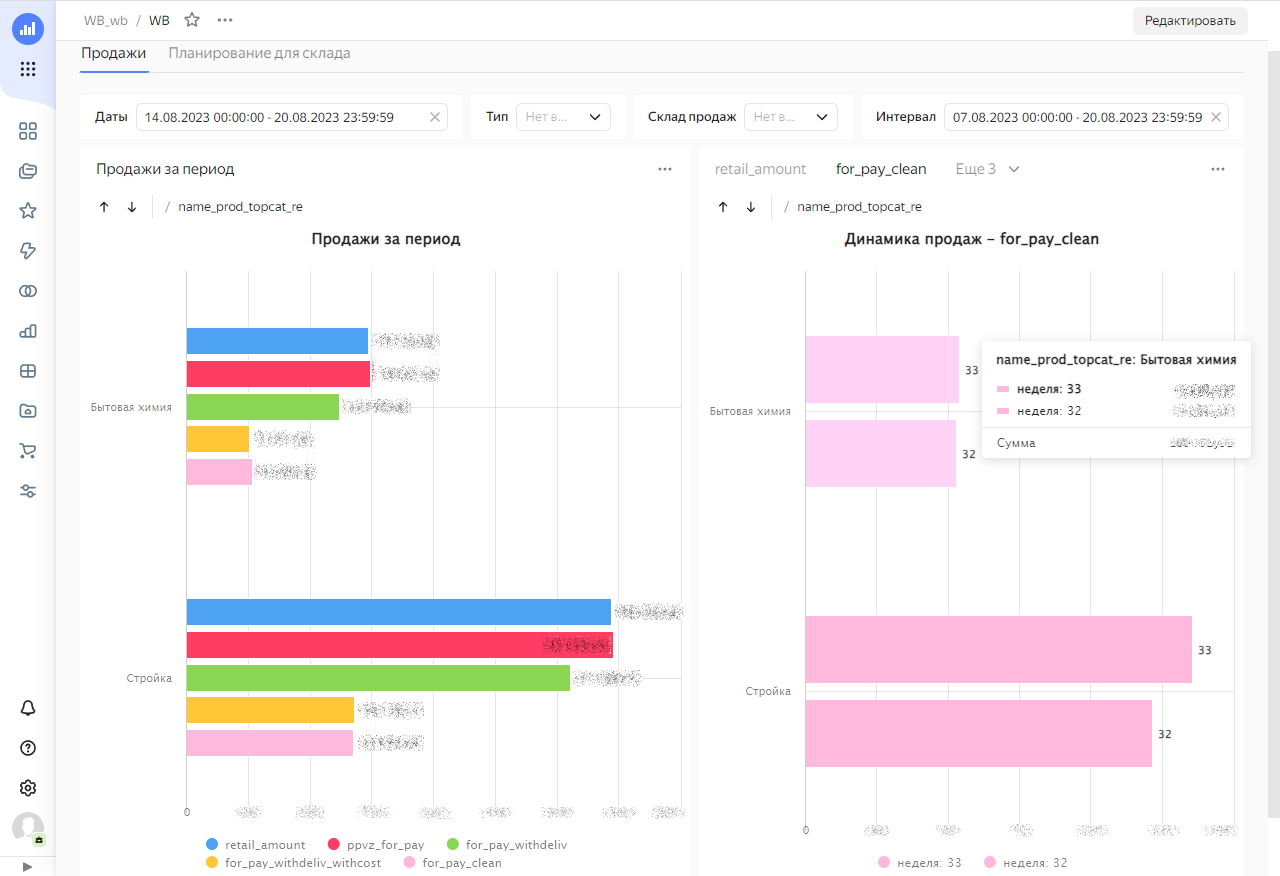

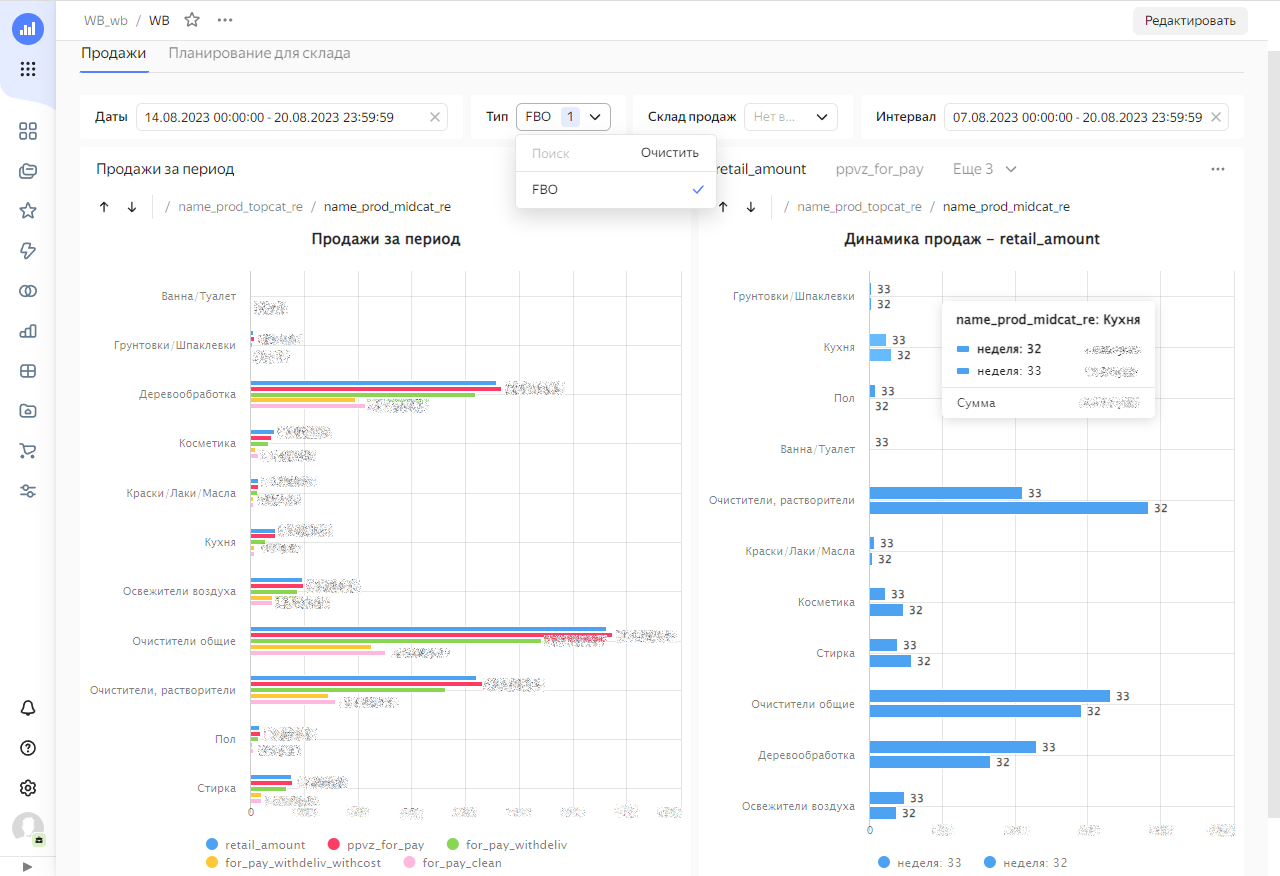

### Дашборд "Планирование для склада"

При формировании дашборда добавлены селекторы: "Даты" (период продаж), "План продаж" (число дней на которое нужно рассчитать предполагаемый объем продаж), "Тип" (выбор модели продаж: FBO), "Склад продаж" (позволяет выбрать склад с которого осуществлена продажа), "Дата" (на какую дату показать остатки на складах). Настроены взаимосвязи селекторов с чартами и между собой.

Ниже приведен скриншот дашборда (наименования товаров скрыты).

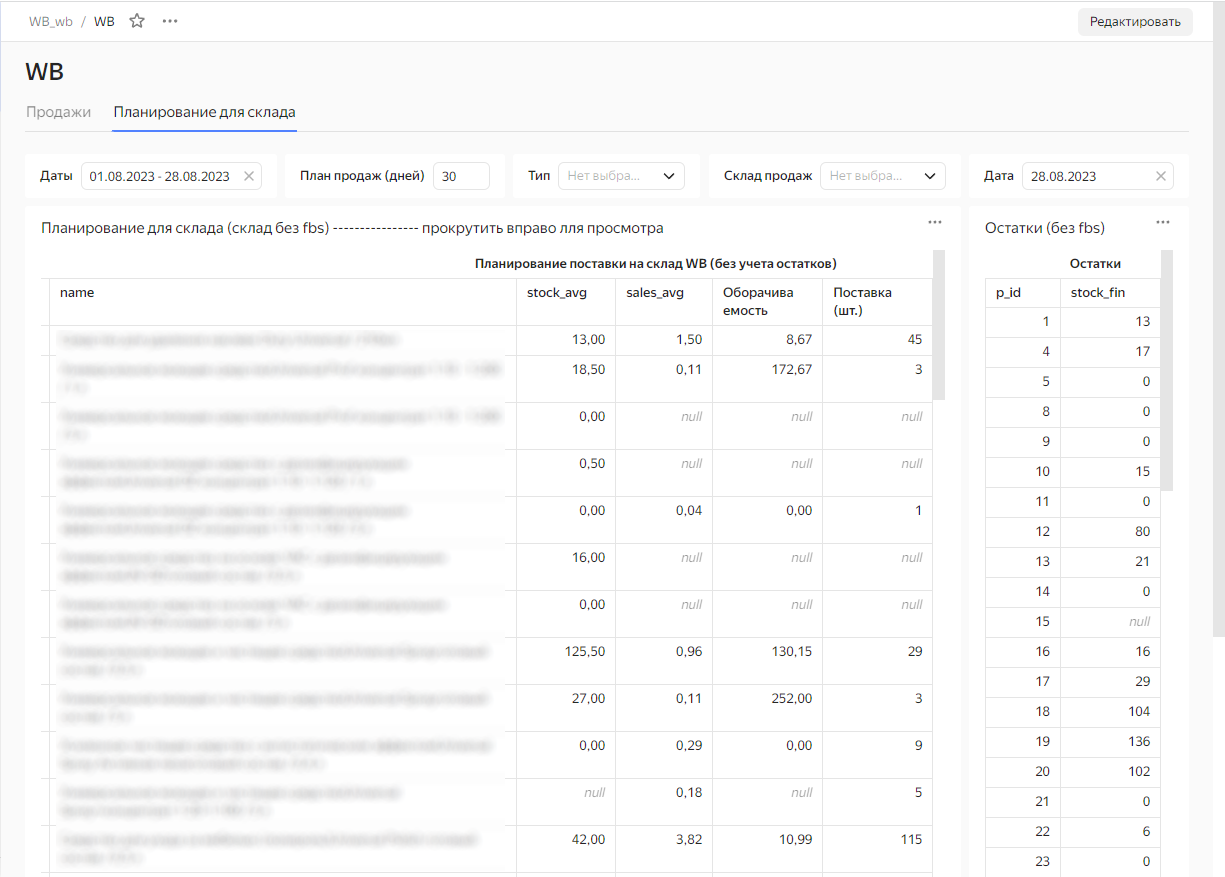

#### Логика дашборда

За определенный период времени для каждого наименования товара (для каждого product_id) дашборд рассчитывает показатели: средний остаток на складах (stock_avg), среднедневные продажи (sales_avg), оборачиваемость (средний остаток деленый на среднедневные продажи), поставка (количество товара в расчете на запланированную продолжительность продаж), остаток (остаток товаров на определенную дату).

Дашборд позволяет оценить по каждой позиции товара оборачиваемость, среднедневные продажи, а также рассчитать какое количество товара необходимо поставить на склады на определенное количество дней продаж. Для подсчете итогового количественного значения плана поставки на склады удобно выгрузить обе таблицы. Далее в табличном процессоре Excel соотнести строки по product_id и рассчитать необходимую величину поставки с учетом текущего остатка на складах. 

## Рекомендации

Рекомендации формирования базы данных к дашборду "Планирование для склада"

* Для корректного расчета оборачиваемости необходимо при каждой итерации вносить в базу данных остатки по всем складам без исключения.
* Для корректного расчета оборачиваемости желательно наличие в базе данных остатков на первый и последний дни периода продаж (значение селектора "Даты"). Механизм расчета подразумевает, что на эти дни приходятся минимальный и максимальный остатки за период. Чем ближе это будет к реальной картине, тем точнее будет расчет.
* Для абсолютно точного расчета оборачиваемости необходимо наличие в базе данных остатков товаров на каждый день периода.